In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.style as style
import matplotlib.pyplot as plt
import scipy.stats as stats
import models as dft
import seaborn as sns
import numpy as np
import functions as f 
from sklearn.metrics import mean_squared_error
import string


style.use('seaborn')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4


In [2]:
# time vector
t = np.linspace(0,600,400)
# TC properties
D_TC = 1.4e-3
rho_TC = 8665
C_TC = 485.6 
A_TC = 4*np.pi*(D_TC/2)**2
V_TC = (4/3)*np.pi*(D_TC/2)**3
eps_TC =0.8
alpha_TC = 0.8

# DFT properties
eps_DFT = 0.94
alpha_DFT =0.94
DFT_area = 0.0762**2
L_DFT =  0.0016
eq_r_DFT = np.sqrt(DFT_area/np.pi)
L_ch_DFT = 0.0762

# Insulation properties
L_ins = .019

# number of nodes
n=10

# where heat flux is imposed
idx_low = int(np.argwhere(t.flatten()<3*60)[-1]) +5
idx_high = int(np.argwhere(t.flatten()> 8*60)[0])

## Compare natural convection assumption and framework

In [3]:
def q_inc_(q, t, t1, t2):
    q = np.ones(t.shape[0])*q
    q[t<t1] = 0
    q[t>t2] = 0
    return q

In [4]:
# heat flux, air temperature, velocity to try
q_inc_try = np.linspace(5e3, 15e3, 6)
T_inf_try = np.linspace(21,200,7)
u_try = np.linspace(0.1,10,7) 

# to store error, convective heat flux, temperature, velocity, heat flux, places where division by zero exists
err_rec = np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))
err_nat = np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))

conv =  np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))
u_i =  np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))
q_i =  np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))
T_inf_i = np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))
zero_problem = np.zeros((u_try.shape[0],T_inf_try.shape[0], q_inc_try.shape[0]))

In [8]:
# iterate through all conditions
for k, heat_flux in enumerate(q_inc_try):  
        
        for i, air_temp in enumerate(T_inf_try):
            
            for j, velocity in enumerate(u_try):
                
                
                # Make synthetic data
                T_inf = f.Cone_Temp(t, 3*60, 8*60, air_temp+273, 21+273)
                T_sur = f.Cone_Temp(t, 3*60, 8*60, 21+273, 21+273)
                T0 = T_inf[0]
                u = np.ones(t.shape[0])*velocity
                q_to_try = q_inc_(heat_flux,t,3*60, 8*60)
                
                forward_model = dft.ForwardModel(n, t, L_ins, L_DFT, q_to_try, u, T0, T_inf, T_sur, eps_DFT, alpha_DFT, eps_TC, alpha_TC,
                 D_TC, V_TC, C_TC, rho_TC, A_TC)
                
                forward_model.run_model()
                
                # temp data
                T_DFT_front = forward_model.temperature_DFT_front
                T_DFT_back = forward_model.temperature_DFT_back
                T_TC = forward_model.temperature_TC
                
                T_eval = 0.5*(T_DFT_front+T_inf)
                nu = dft.air_props(T_eval, Kelvin=True).nu
                Gr = 9.81 * 1 / (0.5 * (T_DFT_front + T_inf)) * (T_DFT_front - T_inf) * 0.0762 ** 3 / nu ** 2
                Re = u * 0.0762 / nu
                h_r = dft.natural_convection(T_DFT_back, Kelvin=True, T_infty=T_inf).custom(0.65, 0.25)[0]
                
                # For recovery
                # forced convection => use framework
                if np.abs(np.mean(Gr/Re**2)) < 1:
                    h_f_actual = dft.Correlations(T_DFT_front, 0.5*(T_DFT_front+T_inf), L_ch_DFT).plate_correlation(u)[0]
                    recover_h = dft.RecoverH(10, t, 1, T_DFT_front, T_DFT_back, L_ch_DFT, T_TC, A_TC, D_TC, T_inf, T_sur, rho_TC, eps_TC, C_TC, V_TC, eps_DFT, idx_low, idx_high)
                    q_inc_recov = recover_h.q_inc_iter
                    h_f = recover_h.h_f
                  
                # nat convection => use nat convection
                else:
                    h_f = dft.natural_convection(T_DFT_front, Kelvin=True, T_infty=T_inf).custom(0.65, 0.25)[0]
                    q_inc_recov=dft.one_dim_conduction(T_DFT_front, T_DFT_back ,t, h_f ,h_r, eps_DFT, model='one_d_conduction', Kelvin=True, T_inf=T_inf, T_sur=T_sur, T_0=T0).q_inc*1e3  
                    h_f_actual = dft.natural_convection(T_DFT_front, Kelvin=True, T_infty=T_inf).custom(0.65, 0.25)[0]
                perc_error = (np.abs(q_inc_recov - q_to_try)/(q_to_try))[idx_low:idx_high]
                perc_error = perc_error[~np.isnan(perc_error)]
                perc_error = perc_error[np.isfinite(perc_error)]
                
                # get error
                err_rec[j,i,k] = np.mean(perc_error)*100
                conv[j,i,k] = np.mean(np.abs(h_f_actual*(T_DFT_front-T_inf))[idx_low:idx_high])
                
                T_inf_i[j,i,k] = air_temp
                u_i[j,i,k] = velocity
                q_i[j,i,k] = heat_flux
                
                # flag cases where temperatures intersect
                if 2 in np.diff(np.sign(T_TC-T_inf)[idx_low:idx_high]):
                    zero_problem[j,i,k]=1
                
                # for natural convection assumption
                h_natural = dft.natural_convection(T_DFT_front, Kelvin=True, T_infty=T_inf).custom(0.65, 0.25)[0] 
                # invert for q_inc using nat convection coefficient
                q_inc_recov=dft.one_dim_conduction(T_DFT_front, T_DFT_back ,t, h_natural ,h_r, eps_DFT, model='one_d_conduction', Kelvin=True, T_inf=T_inf, T_sur=T_sur, T_0=T0).q_inc*1e3    
                
                perc_error = (np.abs(q_inc_recov - q_to_try)/(q_to_try))[idx_low:idx_high]
                perc_error = perc_error[~np.isnan(perc_error)]
                perc_error = perc_error[np.isfinite(perc_error)]
                
                # get error
                err_nat[j,i,k] = np.mean(perc_error)*100      

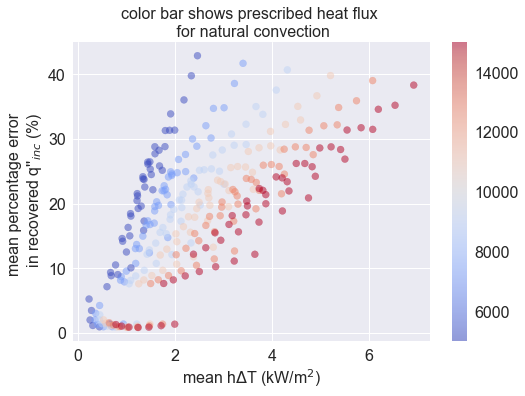

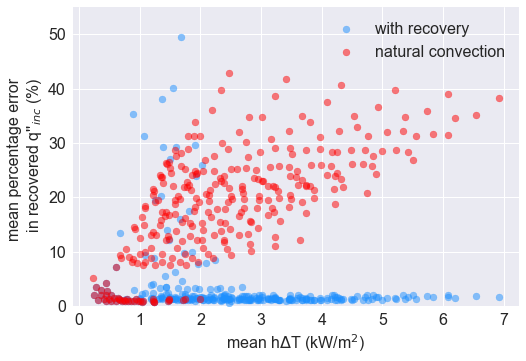

In [9]:
c = plt.scatter(conv/1000, err_nat, c=q_i, cmap=plt.cm.coolwarm, alpha=0.5);
cbar=plt.colorbar(c)
plt.xlabel('mean h$\Delta$T (kW/m$^2$)')
plt.ylabel("mean percentage error \n in recovered q''$_{inc}$ (%)")
plt.title('color bar shows prescribed heat flux \n for natural convection')

plt.figure()

plt.scatter(conv/1000, err_rec, color='dodgerblue', alpha=0.5, label='with recovery')
plt.scatter(conv/1000, err_nat, color='red', alpha=0.5, label='natural convection')

plt.legend()
plt.ylim(0,55)
plt.xlabel('mean h$\Delta$T (kW/m$^2$)')
plt.ylabel("mean percentage error \n in recovered q''$_{inc}$ (%)");

In [10]:
mask = zero_problem != 1
err_rec_mask = err_rec[mask == 1]
err_nat_mask = err_nat[mask == 1]

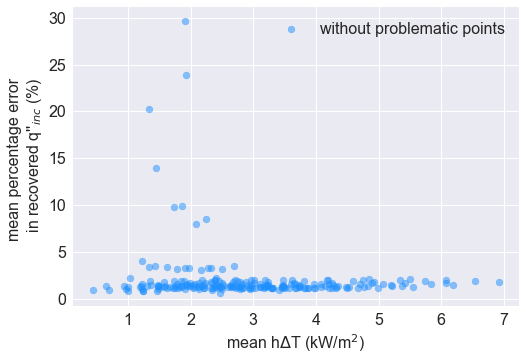

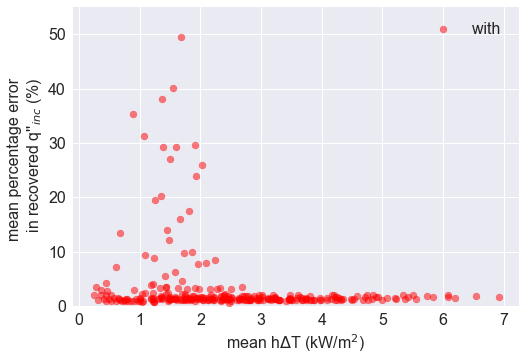

In [11]:
plt.scatter(conv[mask == 1]/1000, err_rec_mask, color='dodgerblue', alpha=0.5, label='without problematic points')
plt.xlabel('mean h$\Delta$T (kW/m$^2$)')
plt.ylabel("mean percentage error \n in recovered q''$_{inc}$ (%)");
plt.legend()
plt.figure()
plt.scatter(conv/1000, err_rec, color='red', alpha=0.5, label='with ')

plt.legend()
plt.ylim(0,55)
plt.xlabel('mean h$\Delta$T (kW/m$^2$)')
plt.ylabel("mean percentage error \n in recovered q''$_{inc}$ (%)");

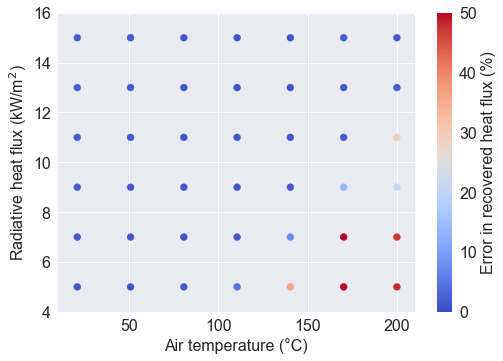

In [12]:
i = 6
#plt.scatter(temp[i,:,:].flatten(), q_inc_repeat, c=err[i,:,:].flatten(), cmap=plt.cm.coolwarm, vmin=0, vmax=15)
# This has to be run with more points to get the same plot as in the paper
fig, ax = plt.subplots()
q_inc_repeat = np.tile(q_inc_try, T_inf_i.shape[1])
c = ax.scatter(np.mean(T_inf_i,axis=0).flatten(), q_inc_repeat/1000, c=np.mean(err_rec, axis=0).flatten(), cmap=plt.cm.coolwarm, vmin=0, vmax=50)
cbar=plt.colorbar(c)
cbar.ax.set_ylabel('Error in recovered heat flux (%)')

ax.set_xlim(10,210)
ax.set_ylim(4,16)
ax.set_xlabel('Air temperature (°C)')
ax.set_ylabel('Radiative heat flux (kW/m$^2$)');


In [13]:
# these numbers are in the paper
mean_error_mask = np.mean(err_nat_mask.flatten()/err_rec_mask.flatten())
mean_error_mask

14.822663709845427

In [14]:
mean_error = np.mean(err_nat.flatten()/err_rec.flatten())
mean_error 

11.448919819200016

## Generate plots for specific conditions

In [24]:
alphabet_string = string.ascii_lowercase
letters=np.array(list(alphabet_string))

In [25]:
def plots_top_hat(u_to_try_array, T_inf, T_sur, q_true, T0):
    fig, axs = plt.subplots(2,3, figsize=(12, 7))
    fig.tight_layout(pad=3.0)
    axs = axs.flatten()
    
    # For natural convection
    for num,u in enumerate(u_to_try_array):
        
        forward_model = dft.ForwardModel(n, t, L_ins, L_DFT, q_true, u, T0, T_inf, T_sur, eps_DFT, alpha_DFT, eps_TC, alpha_TC,
                 D_TC, V_TC, C_TC, rho_TC, A_TC)
        forward_model.run_model()
        # temp data
        T_DFT_front = forward_model.temperature_DFT_front
        T_DFT_back = forward_model.temperature_DFT_back
        T_TC = forward_model.temperature_TC
        
        C = 0.65
        n_ = 0.25
        h_r = dft.natural_convection(T_DFT_back, Kelvin=True, T_infty = T_inf).custom(C, n_)[0]
        
        # Assume natural convection
        h_f = dft.natural_convection(T_DFT_front, Kelvin=True, T_infty = T_inf).custom(C, n_)[0]
        
        T_eval = (T_inf + T_DFT_front)/2
        h_actual = dft.Correlations(T_DFT_front, T_eval, L_ch_DFT).plate_correlation(u)[0]
        q_inc_recov = dft.one_dim_conduction(T_DFT_front, T_DFT_back ,t, h_f,h_r, eps_DFT, model='one_d_conduction', Kelvin=True, T_inf=T_inf, T_sur=T_sur, T_0=T0).q_inc*1e3    
        q_conv_recov = -h_f*(T_DFT_front - T_inf)
        q_conv_actual = -h_actual*(T_DFT_front - T_inf)
        
        max_err_q = mean_squared_error(q_inc_recov/1000,q_true/1000)
        max_err_q = np.round(max_err_q,1)
    
        axs[num].plot(t,q_true/1000, color='red',alpha=.3, linestyle ='--',label="q''$_{inc}$ actual")
        axs[num].plot(t,q_inc_recov/1000,color='red', label="q''$_{inc}$ recovered")
        axs[num].set_ylim(-6,10)
        axs[num].set_xlim(0,t[-1])
        axs[num].plot(t,q_conv_actual/1000,color='dodgerblue',  label="q''$_{conv}$ actual",alpha=.3,linestyle='--')
        axs[num].plot(t,q_conv_recov/1000,color='dodgerblue', label="q''$_{conv}$ recovered")
        axs[num].set_ylim(-7,12)
        axs[0].set_ylabel("Heat flux (kW/m$^2$)", position=(-10,0))
        axs[4].set_xlabel('Time (s)')
        axs[num].set_title('({}) u = {} m/s MSE {} kW/m$^2$'.format(letters[num],np.round(np.mean(u),1),max_err_q))
        if num == 4:
            axs[num].legend(ncol=4,bbox_to_anchor=(2.1, -.2))
    

        # with recovery
        recover_h = dft.RecoverH(10, t, 1, T_DFT_front, T_DFT_back, L_ch_DFT, T_TC, A_TC, D_TC, T_inf, T_sur, rho_TC, eps_TC, C_TC, V_TC, eps_DFT, idx_low, idx_high)
        q_recovered = recover_h.q_inc_iter
        h_recovered = recover_h.h_f
        q_conv_recov = -h_recovered*(T_DFT_front - T_inf)
        
        # calculate errors
        max_err_q = mean_squared_error(q_recovered/1000,q_true/1000)
        max_err_q = np.round(max_err_q,1)
        
        max_err_h = mean_squared_error(h_recovered[idx_low:idx_high],h_actual[idx_low:idx_high])
        max_err_h = np.round(max_err_h,1)
        
        axs[num+3].plot(t,q_true/1000, color='red',alpha=.3, linestyle ='--', label="q''$_{inc}$ actual")
        axs[num+3].plot(t,q_recovered/1000,color='red', label="q''$_{inc}$ recovered")
        axs[num+3].plot(t,q_conv_actual/1000,color='dodgerblue', label="q''$_{conv}$ actual",alpha=.3,linestyle='--')
        axs[num+3].plot(t,q_conv_recov/1000,color='dodgerblue', label="q''$_{conv}$ recovered")
        axs[num+3].set_ylim(-7,12)
        axs[num+3].set_xlim(0,t[-1])
        axs[num+3].set_title('({}) u = {} m/s, MSE {} kW/m$^2$'.format(letters[num+3],np.round(np.mean(u),2), max_err_q))
        
            
        
        

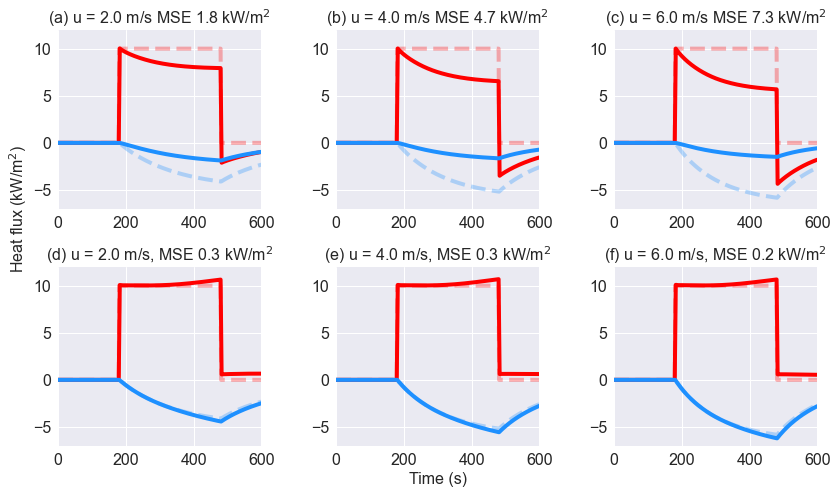

In [26]:
T_inf = f.Cone_Temp(t, 3*60, 8*60, 21+273, 21+273)
T_sur = np.repeat(21+273, t.shape[0])
T0 = T_sur[0]
q_true = q_inc_(10e3,t, 3*60,8*60)
u_to_try = np.linspace(2,6,3)
u_to_try_array = np.repeat([u_to_try], t.shape[0]).reshape(u_to_try.shape[0],t.shape[0])

plots_top_hat(u_to_try_array, T_inf, T_sur, q_true, T0)

In [15]:
def plots_transient(u_to_try_array, T_inf, T_sur, q_true, T0):
    
    fig, axs = plt.subplots(2,3, figsize=(12, 7))
    fig.tight_layout(pad=3.0)
    axs = axs.flatten()

    for num,u in enumerate(u_to_try_array):
        
        forward_model = dft.ForwardModel(n, t, L_ins, L_DFT, q_true, u, T0, T_inf, T_sur, eps_DFT, alpha_DFT, eps_TC, alpha_TC,
                 D_TC, V_TC, C_TC, rho_TC, A_TC).run_model()
        forward_model.run_model()
                
        # temp data
        T_DFT_front = forward_model.temperature_DFT_front
        T_DFT_back = forward_model.temperature_DFT_back
        T_TC = forward_model.temperature_TC
      
        C = 0.65
        n_ = 0.25
        h_r = dft.natural_convection(T_DFT_back, Kelvin=True, T_infty = T_inf).custom(C, n_)[0]
        
        # Assume natural convection
        h_f = dft.natural_convection(T_DFT_front, Kelvin=True, T_infty = T_inf).custom(C, n_)[0]
        
        T_eval = (T_inf + T_DFT_front)/2
        h_actual = dft.Correlations(T_DFT_front, T_eval, L_ch_DFT).plate_correlation(u)[0]
        q_inc_recov = dft.one_dim_conduction(T_DFT_front, T_DFT_back ,t, h_f,h_r, eps_DFT, model='one_d_conduction', Kelvin=True, T_inf=T_inf, T_sur=T_sur, T_0=T0).q_inc*1e3    
        q_conv_recov = -h_f*(T_DFT_front - T_inf)
        q_conv_actual = -h_actual*(T_DFT_front - T_inf)
        
        max_err_q = mean_squared_error(q_inc_recov/1000,q_true/1000)
        max_err_q = np.round(max_err_q,1)
    
        axs[num].plot(t,q_true/1000, color='red',alpha=.3, linestyle ='--',label="q''$_{inc}$ actual")
        axs[num].plot(t,q_inc_recov/1000,color='red', label="q''$_{inc}$ recovered")
        axs[num].set_ylim(-6,10)
        axs[num].set_xlim(0,t[-1])
        axs[num].plot(t,q_conv_actual/1000,color='dodgerblue',  label="q''$_{conv}$ actual",alpha=.3,linestyle='--')
        axs[num].plot(t,q_conv_recov/1000,color='dodgerblue', label="q''$_{conv}$ recovered")
        axs[num].set_ylim(-7,12)
        axs[0].set_ylabel("Heat flux (kW/m$^2$)", position=(-10,0))
        axs[4].set_xlabel('Time (s)')
        axs[num].set_title('({}) u = {} m/s MSE {} kW/m$^2$'.format(letters[num],np.round(np.mean(u),1),max_err_q))
        if num == 4:
            axs[num].legend(ncol=4,bbox_to_anchor=(2.1, -.2))
        
    
        # with recovery
        recover_h = dft.RecoverHtransient(10, t, 1, T_DFT_front, T_DFT_back, L_ch_DFT, T_TC, A_TC, D_TC, T_inf, T_sur, rho_TC, eps_TC, C_TC, V_TC, eps_DFT)
        q_recovered = recover_h.q_inc_iter
        h_recovered = recover_h.h_f
        q_conv_recov = -h_recovered*(T_DFT_front - T_inf)
        
        # calculate errors
        max_err_q = mean_squared_error(q_recovered/1000,q_true/1000)
        max_err_q = np.round(max_err_q,1)
        
        max_err_h = mean_squared_error(h_recovered[idx_low:idx_high],h_actual[idx_low:idx_high])
        max_err_h = np.round(max_err_h,1)
        
        axs[num+3].plot(t,q_true/1000, color='red',alpha=.3, linestyle ='--', label="q''$_{inc}$ actual")
        axs[num+3].plot(t,q_recovered/1000,color='red', label="q''$_{inc}$ recovered")
        axs[num+3].plot(t,q_conv_actual/1000,color='dodgerblue', label="q''$_{conv}$ actual",alpha=.3,linestyle='--')
        axs[num+3].plot(t,q_conv_recov/1000,color='dodgerblue', label="q''$_{conv}$ recovered")
        axs[num+3].set_ylim(-7,12)
        axs[num+3].set_xlim(0,t[-1])
        axs[num+3].set_title('({}) u = {} m/s, MSE {} kW/m$^2$'.format(letters[num+3],np.round(np.mean(u),2), max_err_q))

In [28]:
def T_inf_ramp(t):
    return ( (70-21)/600**2*t**2 + 21) + 273

In [29]:
def q_curves(t):
    q= 10000/(600**2)*t**2
    return q 

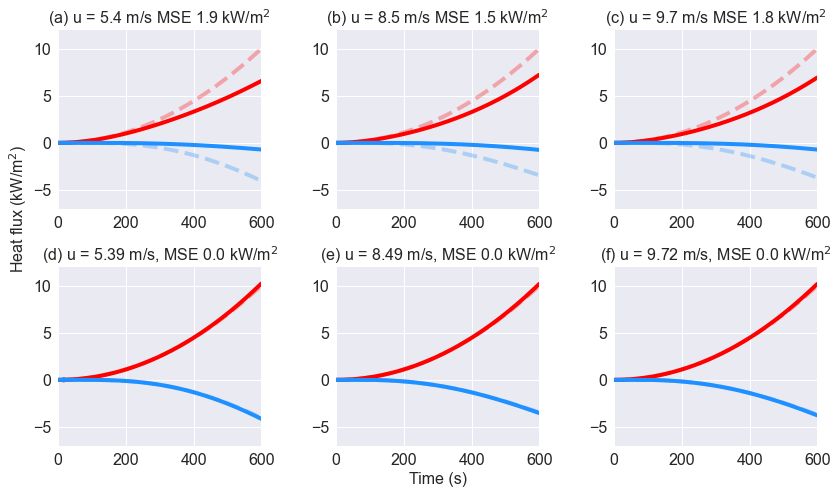

In [30]:
T_inf = T_inf_ramp(t)
T_sur = np.repeat(21+273, t.shape[0])
T0 = T_inf[0]
q_true =  q_curves(t)

u_to_try_array = np.zeros((3,t.shape[0]))
for num in range(3):
    u_to_try_array[num,:] = f.generate_u_lin(t)
    
plots_transient(u_to_try_array, T_inf, T_sur, q_true, T0)